In [22]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def rename(full_name):
    if full_name == "United States":
        return "USA"
    elif full_name == "United Kingdom":
        return "GBR"
    elif full_name == "Spain":
        return "ESP"
    elif full_name == "Italy":
        return "ITA"
    elif full_name == "Germany":
        return "DEU"
    
#data cleaning
five_country = pd.read_csv('fivecountrydata.csv')
five_country['TIME'] = five_country['date'].apply(lambda x: x[:7])
five_country['LOCATION'] = five_country['location'].apply(rename)
five_country = five_country.groupby(['LOCATION','TIME']).sum().reset_index()

share_price = pd.read_csv('shareprice.csv')
share_price = share_price[['LOCATION','TIME','share_price_value']].groupby(['LOCATION','TIME']).sum().reset_index()

inflation = pd.read_csv('inflation.csv')
inflation = inflation[['LOCATION','TIME','cpi']].groupby(['LOCATION','TIME']).sum().reset_index()


from functools import partial,reduce

In [23]:
dfs = [five_country, share_price, inflation]
merge = partial(pd.merge, on = ['LOCATION','TIME'], how = 'inner')
df = reduce(merge, dfs)
df.columns
df['new_case_rate'] = df['total_cases'].pct_change()
df['new_case_rate']

import numpy as np

df['new_case_rate'][np.isinf(df['new_case_rate'])] = np.nan
df['new_case_rate']
df['inflation_rate'] = df['cpi'].pct_change()
df.isnull().sum()

from sklearn.impute import SimpleImputer

#fills missing values with mean
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
#fits transformer to X & Y with optional parameters fit_params & returns a transformed version of X
df['new_case_rate'] =  imputer.fit_transform(df[['new_case_rate']])
df['death_rate'] = df['total_deaths'] / df['total_cases']
df['death_rate'] =  imputer.fit_transform(df[['new_case_rate']])
#df['death_rate'] =  imputer.fit_transform(df[['death_rate']])
df['death_rate']

df['inflation_rate'] =  imputer.fit_transform(df[['inflation_rate']])
df['inflation_rate']

#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x, y = df[['new_case_rate','death_rate']] , df['inflation_rate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

clf = LinearRegression()
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("r2 score = " + str(r2))        #r2 = -2.194441211117783

r2 score = -3.0478484546990723


In [4]:
#Lasso Regression

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

clf = Lasso(alpha = 0.3)
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("r2 score = " + str(r2))     # r2 = -2.719475147293018

r2 score = -2.719475147293018


In [5]:
#Ridge Regression

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

clf = Ridge(alpha = 0.3)
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("r2 score = " + str(r2))     # r2 = -3.0478481551359113

r2 score = -3.0478481551359113


In [6]:
#Logistic Regression for share price

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sn

#European 19 countries' share price in 2019 is 104.92 and USA is 120.4798
bi = []

for i in range(len(df['share_price_value'])):
    if df['share_price_value'][i] >= 120.4798 and df['LOCATION'][i] == 'USA':
        bi.append(1)
    elif df['share_price_value'][i] < 120.4798 and df['LOCATION'][i] == 'USA':
        bi.append(0)
    elif df['share_price_value'][i] < 104.92 and df['LOCATION'][i] != 'USA':
        bi.append(0)
    elif df['share_price_value'][i] >= 104.92 and df['LOCATION'][i] != 'USA':
        bi.append(1)
        
df['binary'] = bi
df['binary']

x = df[['new_case_rate','death_rate']]
y = df['binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
clf = LogisticRegression(C = 1.0, class_weight = None, dual = False, fit_intercept = True,
          intercept_scaling = 1, max_iter = 100, multi_class = 'ovr', n_jobs = 1,
          penalty = 'l2', random_state = None, solver = 'liblinear', tol = 0.0001,
          verbose = 0, warm_start = False)

#relevant documents in dataset
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(y_pred)
#F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1
f1 = f1_score(y_test, y_pred)
print("f1 score = " + str(f1))


[1 0 0 1 0]
f1 score = 0.8


tn:  2 
fp:  0 
tp:  2 
fn:  1


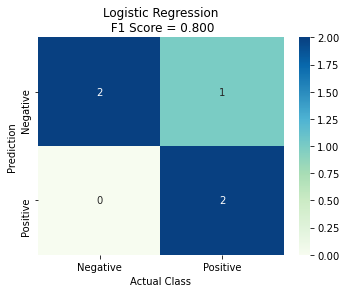

In [7]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn.metrics as skm

cm = confusion_matrix(y_pred, y_test)

labels = ["Negative","Positive"]
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

#plot figure
plt.figure(figsize = (5.5,4))
sns.heatmap(df_cm, cmap = "GnBu", annot = True)
tn, fp, fn, tp = skm.confusion_matrix(y_test,y_pred).ravel()
print("tn: ",tn,"\nfp: ",fp,"\ntp: ",tp,"\nfn: ",fn)

plt.title("Logistic Regression\n F1 Score = {0:.3f}".format(f1_score(y_test, y_pred)))
plt.xlabel("Actual Class")
plt.ylabel("Prediction")
plt.show()

In [8]:
#Logistic Regression for inflation rate

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#world inflation rate in 2019 was 1.76%
bi = []

for i in df['inflation_rate']:
    if i >= 0.00176:
        bi.append(1)
    else:
        bi.append(0)
        
df['binary'] = bi
df['binary']

x = df[['new_case_rate','death_rate']]
y = df['binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#relevant documents in dataset
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(y_pred)
f1 = f1_score(y_test, y_pred)
print("f1 score = " + str(f1))


[1 1 1 1 0]
f1 score = 0.75


tn:  0 
fp:  1 
tp:  3 
fn:  1


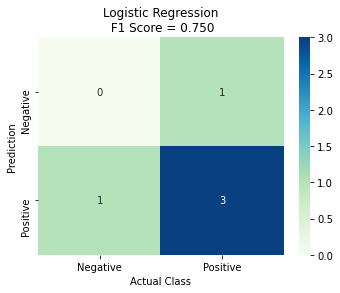

In [9]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.metrics as skm

cm = confusion_matrix(y_pred, y_test)

labels = ["Negative","Positive"]
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

#plot figure
plt.figure(figsize = (5.5,4))
sns.heatmap(df_cm, cmap = "GnBu", annot = True)
tn, fp, fn, tp = skm.confusion_matrix(y_test,y_pred).ravel()
print("tn: ",tn,"\nfp: ",fp,"\ntp: ",tp,"\nfn: ",fn)

plt.title("Logistic Regression\n F1 Score = {0:.3f}".format(f1_score(y_test, y_pred)))
plt.xlabel("Actual Class")
plt.ylabel("Prediction")
plt.show()

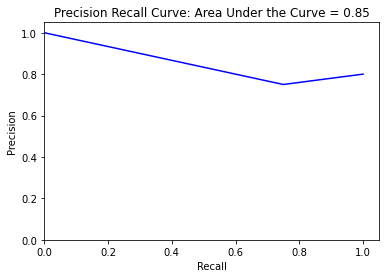

In [10]:
precision_prc, recall_prc, thresholds_prc = skm.precision_recall_curve(y_test, y_pred, pos_label = 1)
prc_auc = skm.auc(recall_prc, precision_prc)

plt.plot(recall_prc, precision_prc, 'b', label= "Precision Recall Curve")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve: Area Under the Curve = %0.2f" % prc_auc)
plt.show()

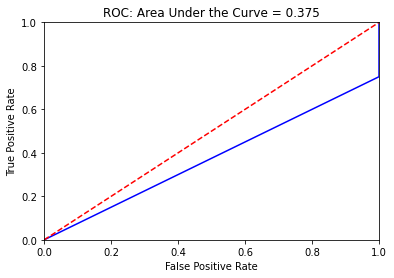

In [11]:
fpr, tpr, threshold = skm.roc_curve(y_test,y_pred, pos_label = 1)
roc_auc = skm.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'Area Under the Curve = %0.3f' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC: Area Under the Curve = %0.3f" % roc_auc)
plt.show()


In [12]:
#ARMA test

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

gdp = pd.read_csv("gdp_growth_rate.csv", index_col = 0)
gdp.index = pd.date_range('1980','2022', freq = 'Y')

def adf_test(series):
    print("**** Is",series.name,"stationary?")
    dftest = adfuller(series, autolag = 'AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value statistic = {:.3f}".format(dftest[1]))
    print("Critical values:")
    
    for k,v in dftest[4].items():
        print("\t{}: {:.3f} - The data is {} stationary with {} % confidence".format(
        k.ljust(4), v, "not" if v < dftest[0] else"", 100 - int(k[:-1])))

adf_test(gdp["USA"])

**** Is USA stationary?
Test statistic = -5.489
P-value statistic = 0.000
Critical values:
	1%  : -3.601 - The data is  stationary with 99 % confidence
	5%  : -2.935 - The data is  stationary with 95 % confidence
	10% : -2.606 - The data is  stationary with 90 % confidence


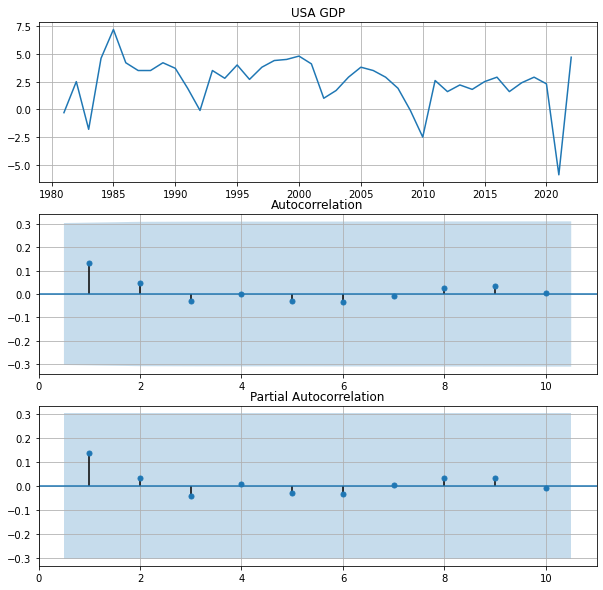

In [24]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplots(3,1,figsize = (10,10))
ax = plt.subplot(3,1,1)
plt.grid()
plt.plot(gdp["USA"])
plt.title("USA GDP")

ax = plt.subplot(3,1,2)
plt.grid()
plot_acf(gdp["USA"], ax, lags = 10, zero = False)

ax = plt.subplot(3,1,3)
plt.grid()
plot_pacf(gdp["USA"], ax, lags = 10, zero = False)
plt.show()

In [14]:
#VAR projection

from statsmodels.tsa.api import VAR

dates = gdp.index

model = VAR(endog = gdp, dates = dates)
model_fit = model.fit()
model_fit.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jun, 2020
Time:                     18:09:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    4.20062
Nobs:                     41.0000    HQIC:                   3.40336
Log likelihood:          -321.291    FPE:                    19.2472
AIC:                      2.94678    Det(Omega_mle):         9.72294
--------------------------------------------------------------------
Results for equation Germany
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.275329         0.766518            1.664           0.096
L1.Germany         0.121023         0.302333            0.400           0.689
L1.Italy          -0.263652         0.474184           -0.556         

[[1.41029279 0.85878792 1.75957152 1.99615297 2.45916185]
 [1.57726108 0.96198994 2.01832699 2.23289886 2.66903667]
 [1.61853205 0.97268357 2.15301578 2.24333576 2.68051035]]


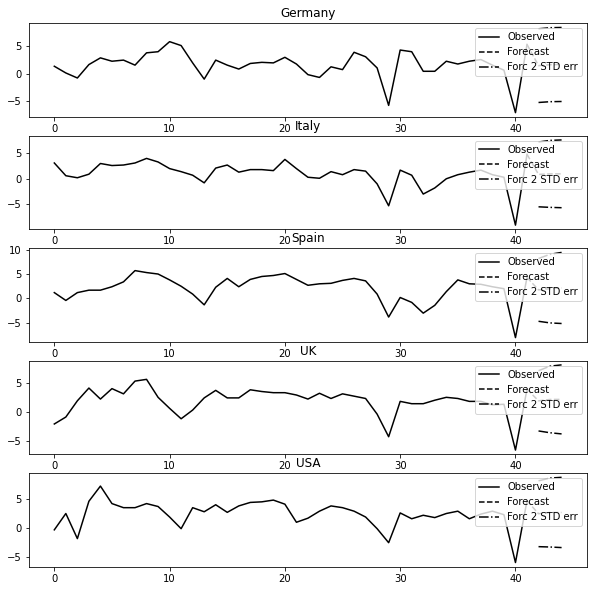

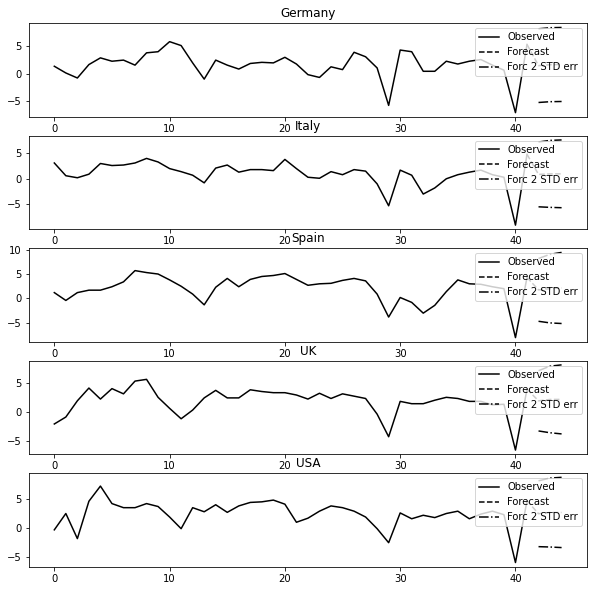

In [17]:
#x-axis days
#y-axis gdp growth
lag_order = model_fit.k_ar
print(model_fit.forecast(gdp.values[lag_order:], 3))
model_fit.plot_forecast(3,alpha = 0.01, plot_stderr = True)

In [18]:
#Forecast Error Variance Decomposition (FEVD) Evaluation

fin = model_fit.fevd(5)
fin.summary()

FEVD for Germany
      Germany     Italy     Spain        UK       USA
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.992110  0.001184  0.002667  0.003772  0.000267
2    0.990920  0.001270  0.002748  0.004771  0.000291
3    0.990690  0.001282  0.002781  0.004955  0.000292
4    0.990593  0.001292  0.002854  0.004969  0.000292

FEVD for Italy
      Germany     Italy     Spain        UK       USA
0    0.802052  0.197948  0.000000  0.000000  0.000000
1    0.756630  0.235711  0.000598  0.004655  0.002407
2    0.741193  0.248627  0.000664  0.006366  0.003149
3    0.736093  0.252561  0.001115  0.006772  0.003458
4    0.734500  0.253551  0.001565  0.006813  0.003571

FEVD for Spain
      Germany     Italy     Spain        UK       USA
0    0.627144  0.250083  0.122773  0.000000  0.000000
1    0.526146  0.308743  0.148744  0.014347  0.002020
2    0.490524  0.336265  0.146054  0.024143  0.003014
3    0.478303  0.347835  0.142054  0.028167  0.003640
4    0.474504  0.351703  0.140609

In [25]:
#forecasting
nobs = 2
pred = model_fit.forecast(model_fit.y, steps = nobs)
df_forecast = pd.DataFrame(pred, index = df.index[-nobs:], columns = gdp.columns + '_1d')
df_forecast.tail()

#inverting transformation
def invert_transformation(df_train, df_forecast, second_diff = False):
    #Revert back to differencing to get the forecast to original scale
    df_fc = df_forecast.copy()
    #print(df_train)
    columns = df_train.columns
    for col in columns:
        #Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2])+df_fc[str(col)+'_1d'].cumsum()
        
        #Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

#show inverted results in a dataframe

df_train, df_test = gdp[0:-nobs], gdp[-nobs:]

df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:,['Germany_forecast','Italy_forecast','Spain_forecast','UK_forecast','USA_forecast']]

#13 -> 2020
#14 -> 2021

,Germany_forecast,Italy_forecast,Spain_forecast,UK_forecast,USA_forecast
13,1.110293,0.658788,3.359572,3.496153,4.159162
14,3.197847,1.979566,6.737470,7.825205,8.687360


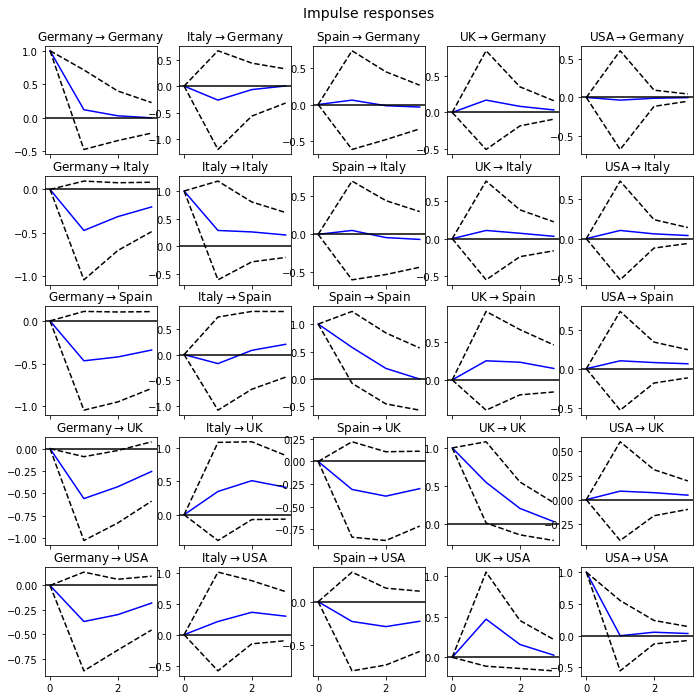

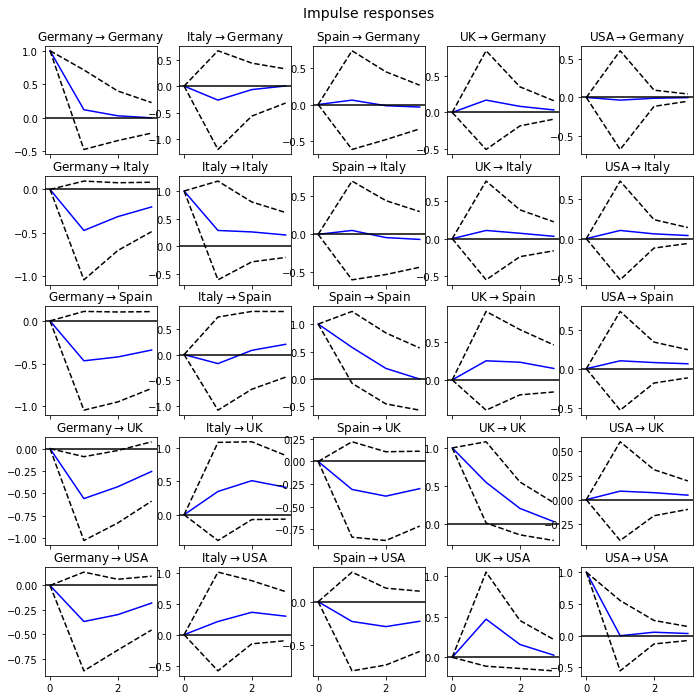

In [20]:
irf = model_fit.irf(3)
irf.plot(orth = False)

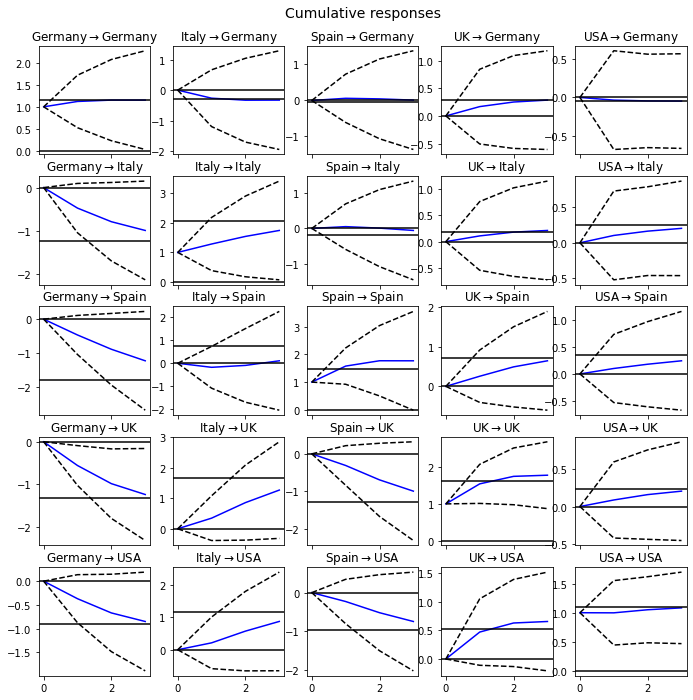

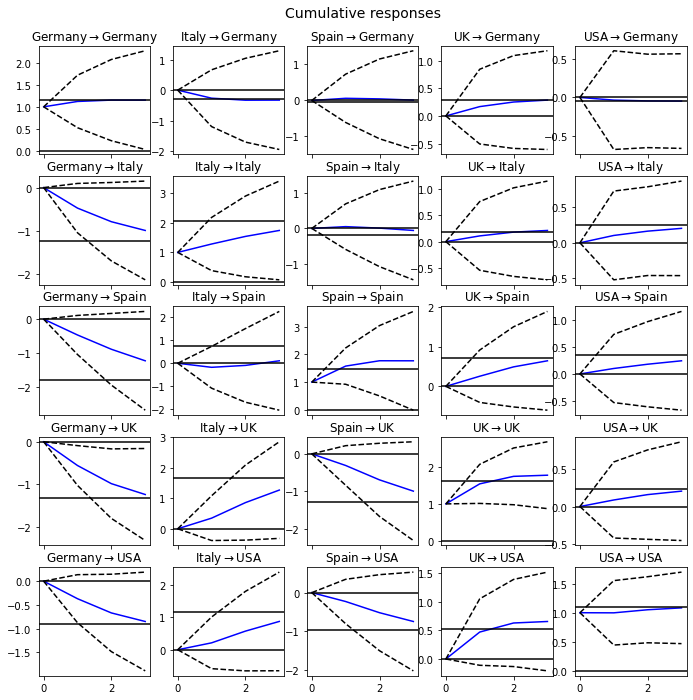

In [21]:
irf.plot_cum_effects(orth=False)